# Analysis of synthetic data for paper on HBAC algorithm 


In this notebook, I conduct an analysis of the HBAC algorithm from [1]. The goal is to create simulation study similar to [1], in order to answer two research questions:

1. What is the effect of using an out-of-sample evaluation of the clusters, rather than in-sample as done in [1]?
2. What is the effect of testing whether or not there is bias via a null-distribution. 

## The data-generating process for the simulation

The original synthetic data is generated using the following data-generating process (DGP)


<img src="hbac_dgp.png" width=1200 height=500>


In this DGP, several things are randomized instead of fixed.
1. The number of clusters, $K$, sampled from a uniform distribution.
2. The number of users in the segment, $n_k$, again sampled from a uniform distribution.
3. The bias metric per cluster, $M_k$, sampled from a normal distribution.
4. The number of outliers, $N_{\mathrm{outliers}}$, sampled from a uniform distribution.

It is also worth noting that:
* The number of features used for the clustering, $d=2$, is fixed.
* It is not clear to me how the input features are distribution, but Figure 1 from [1] appears to indicate these are normally distribution with varying means and variances.


**I prefer a different approach where many of the above parameters are fixed**.This is because this allows us to study how the performance of HBAC will differ as this value of the parameter changes. 

* Fix the number of clusters $K$, varying between values {2, 5, 10}. 
* I will vary the dimensionality $d$ between {2, 10, 50}
* Fix the total number of datapoints $N$ and vary between {1000, 10000}. 
* The number of datapoints _per cluster_ is the same per cluster, e.g. if we have 1000 datapoints, 5 clusters, then  $N_k = 200$ per cluster. 
* I do not introduce any outliers. 

As for the bias metric, we can choose between several options. 
* In the set-up of [1], the bias metric is separately generated, and no model is fitted. In our code, this is equivalent to using *target_col=y* and $y_dgp=random$. 
* Alternatively, one can fit a model to determine the bias metric, e.g. focus on demographic parity via *target_col=y_pred*, or its errors via *target_col=err*. 
* We need to decide whether or not the bias is continuous or binary. I have added the option to set *binary_y=False*, in which case we fit a linear regression instead of a logistic regression. 


**Open question on choice of hyper-parameters**: in this case, I give the HBAC algorithm 'foreknowledge', e.g. if we create 5 clusters, I put a maximum of 5 iterations in the algorithm. We should probably do a separate investigation on how the hyper-parameters should be selected (in-sample vs. out-of-sample)


The notebook is structured as follows:
1. I first go over a simple example and illustrate the answer to the first research question: in-sample evaluation means that we find bias, even for metrics that are independent of the clustering (such as errors).
2. I then illustrate that this this answer does not change when changing $d$, $N$, or $K$. 


[1] Joanna Misztal-Radecka, Bipin Indurkhya. Bias-Aware Hierarchical Clustering for detecting the discriminated groups of users in recommendation systems,
Information Processing & Management, Volume 58, Issue 3,2021. 


In [ ]:
import pandas as pd
import seaborn as sns
from analysis_utils import plot_diff_in_bias

# Simple example

In this case, we show the effect of in-sample vs. out-of-sample evaluation for a simple data-generating process, where $K=10$, $N=1000$, $d=2$, and the $y$ is continuous. 

In [ ]:

# need `pyarrow` package to load parquet files
df = pd.read_csv('results_clust_original_paper.csv')
df.head()

# set these for the subsequent analysis
K = 5
N = 1000
d= 2
method = 'hbac'
binary_y = False
bonf_corr = False
df_simple = df[(df['K'] == K) & (df['N'] == N) & (df['method'] == method) & (df['d'] == d) & (df['binary_y'] == binary_y) & (df['bonf_corr'] == bonf_corr)]



target_col_map = {'y': r'$y$', 'y_pred': r'$\hat{y}$', 'err': r'Error'}

# filter the data
df_simple = df[(df['K'] == K) & (df['N'] == N) & (df['method'] == method)]

## Without difference in the metric, in-sample

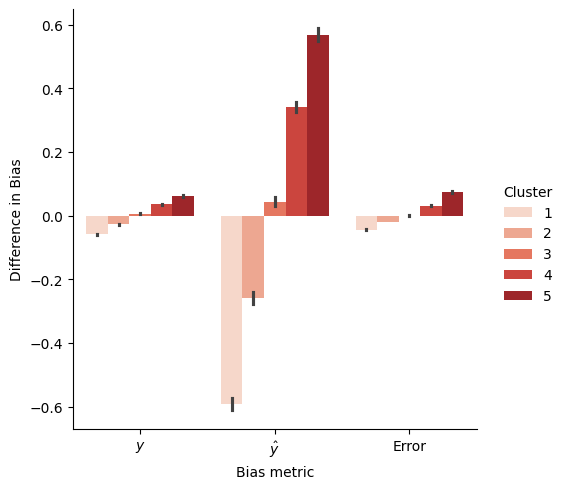

In [223]:


# select the df with specific train_fit
fit_train = False
y_dgp = 'constant'
df_simple_no_diff_in_sample = df_simple[(df_simple['fit_train'] == fit_train) & (df_simple['y_dgp'] == y_dgp)]

# create plot
plot_diff_in_bias(df_simple_no_diff_in_sample, target_col_map=target_col_map, color_set='Reds')

## With difference in the metric, in-sample

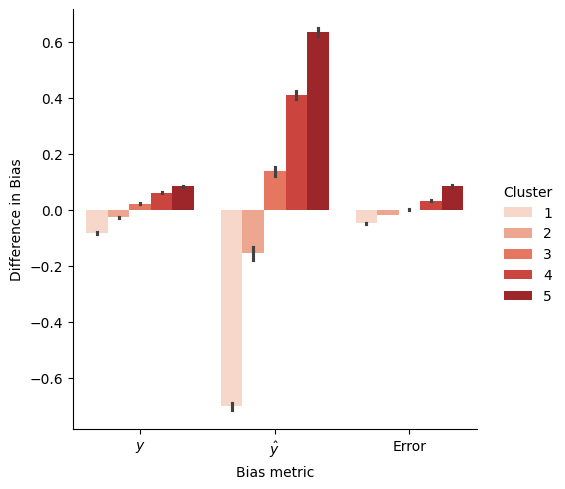

In [224]:


# select the df with specific train_fit
fit_train = False
y_dgp = 'linear'
df_simple_diff_in_sample = df_simple[(df_simple['fit_train'] == fit_train) & (df_simple['y_dgp'] == y_dgp)]

# create plot
plot_diff_in_bias(df_simple_diff_in_sample, target_col_map=target_col_map, color_set='Reds')


## Without difference in metric, out-of-sample

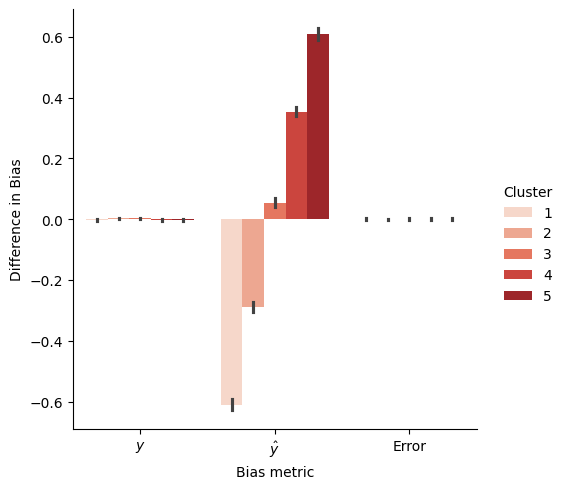

In [225]:


# select the df with specific train_fit
fit_train = True
y_dgp = 'constant'
df_simple_no_diff_out_sample = df_simple[(df_simple['fit_train'] == fit_train) & (df_simple['y_dgp'] == y_dgp)]

# create plot
plot_diff_in_bias(df_simple_no_diff_out_sample, target_col_map=target_col_map, color_set='Reds')

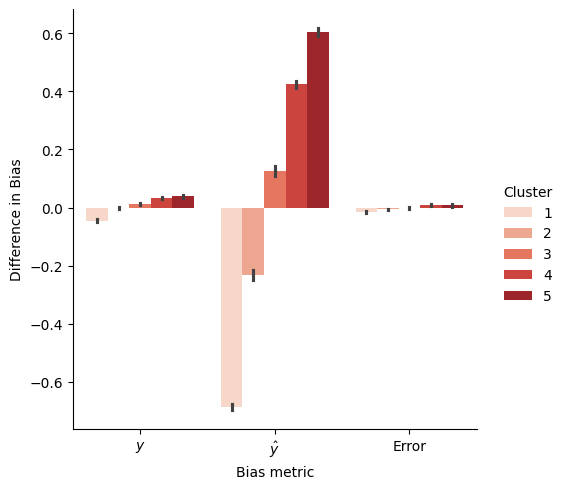

In [226]:


# select the df with specific train_fit
fit_train = True
y_dgp = 'linear'
df_simple_diff_out_sample = df_simple[(df_simple['fit_train'] == fit_train) & (df_simple['y_dgp'] == y_dgp)]

# create plot
plot_diff_in_bias(df_simple_diff_out_sample, target_col_map=target_col_map, color_set='Reds')